<a href="" target="_blank">
  <button style="background-color:#0072ce; color:white; padding:0.6em 1.2em; font-size:1rem; border:none; border-radius:6px; margin-top:1em;">
    🚀 Launch this notebook in JupyterLab
  </button>
</a>

### Introduction

In this notebook, we will explore additional functionalities that can be applied to Sentinel-1 GRD data. Continuing to access the data through the EOPF Zarr sample services, we will learn how to visualize and carry out basic SAR operations, such as georeferencing and backscatter calibration, using the `.zarr` format.

### What we will learn

- 🗺️ How to georeference a Sentinel-1 GRD image using the correct latitude and longitude coordinates?
- ✳ How to calibrate the amplitude over a Sentinel-1 GRD product?
- ✨ How to calibrate the intensity with dB over a Sentinel-1 GRD product?

### Prerequisites

This tutorial uses a re-processed sample dataset from the [EOPF Sentinel Zarr Samples Service STAC API](https://stac.browser.user.eopf.eodc.eu/?.language=en), the same used on the previous [chapter](23_zarr_structure_S1GRD.ipynb):
- `S1A_IW_GRDH_1SDV_20170508T164830_20170508T164855_016493_01B54C_8604`

Additionally, it is uselful to install the extra dependencies from this environment. To do it we just need to run the following command:
```bash
uv sync --all-extras
```



<hr>

#### Import libraries

In [105]:
import xarray as xr # Basic package to deal with data arrays
import xarray_sentinel # Handles most basic SAR operations
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np

<hr>

## Georeferencing GRD product

As seen in the previous [chapter](23_zarr_structure_S1GRD.ipynb), plotting a **Sentinel-1 GRD** item displays an image with `azimuth_time` and `ground_range`coordinates. While these are indeed valid coordinates for **Sentinel-1** products, they are only meaningful within the context of image acquisition. <br>

To compare them with other geospatial datasets or to examine their actual location on Earth, the data needs to be georeferenced using geographic coordinates, such as **latitude** and **longitude**.

### Opening the product

As usual, the first step is to open the Sentinel-1 GRD product we are going to work with. Using the well know functions `open_datatree()` and `open_dataset()`, we open the `.zarr`product.

In [69]:
url = "https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_b716/S1A_IW_GRDH_1SDV_20170508T164830_20170508T164855_016493_01B54C_8604.zarr"
dt = xr.open_datatree(url, engine='zarr', chunks={})

We can access `.groups` and explore what is inside the polarisation group, as it corresponds to the information we will be working with.<br>
This is going to help us later opening specific subgroups, such as `measurements`subgroup.

In [70]:
dt.S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH.groups

('/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/measurements',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/quality',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/antenna_pattern',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/attitude',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/azimuth_fm_rate',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/coordinate_conversion',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/doppler_centroid',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/gcp',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/orbit',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/reference_replica',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/replica',
 '/S01SIWGRD_20170508T164

In [73]:
measurements = dt["S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/measurements"].to_dataset()

As the `measurements.grd`array is large to be directly plotted, we need to slice it. Applying the `.isel()`method is useful in this case.<br>
We observe that the `grd` product coordinates `azimuth_time` and `ground_range` and not stored in geographical coordinates.

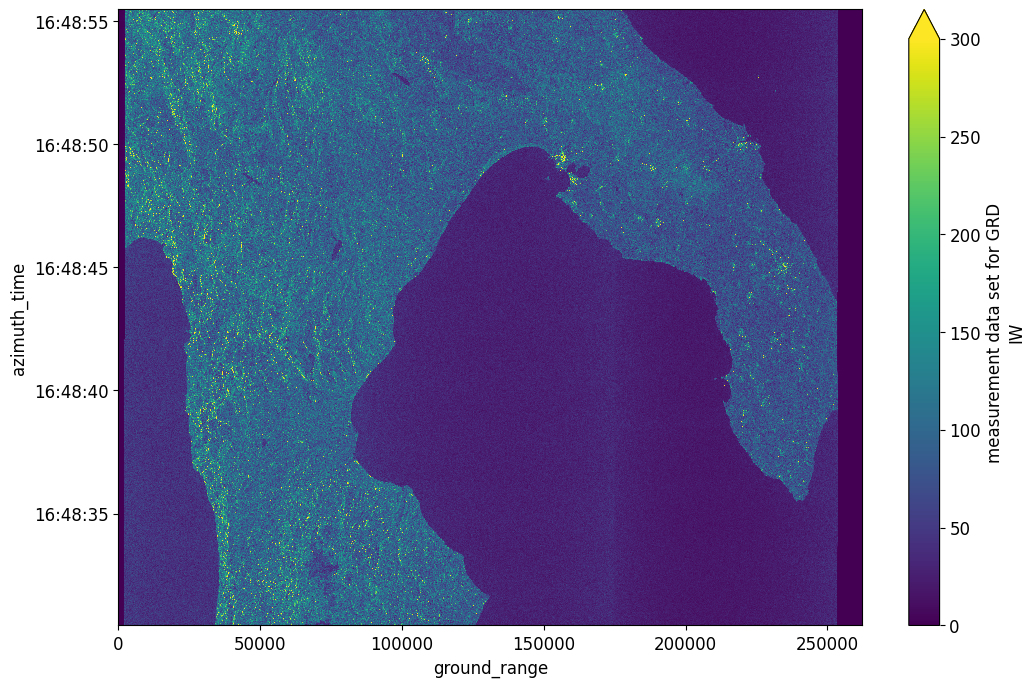

In [ ]:
grd = measurements.grd.isel(
    azimuth_time=slice(None, None, 10), ground_range=slice(None, None, 10)
)
grd.plot(vmax=300)
plt.show()

### Setting the GCP

In order to **georeference** the image with the correspondent latitude and longitude coordinates, we need to access and use the ground control points stored into the `.zarr` structure.<br>

These are well known points that contain both the latitude and longitude coordinates but also the azimuth time and ground range coordinates, making it possible to georeference the `grd` image.

In [74]:
ground_control_point = dt["S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/gcp"].to_dataset()
ground_control_point

<xarray.Dataset> Size: 12kB
Dimensions:               (azimuth_time: 10, ground_range: 21)
Coordinates:
  * azimuth_time          (azimuth_time) datetime64[ns] 80B 2017-05-08T16:48:...
  * ground_range          (ground_range) float64 168B 0.0 ... 2.624e+05
    line                  (azimuth_time) uint32 40B dask.array<chunksize=(10,), meta=np.ndarray>
    pixel                 (ground_range) uint32 84B dask.array<chunksize=(21,), meta=np.ndarray>
Data variables:
    azimuth_time_gcp      (azimuth_time, ground_range) datetime64[ns] 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    elevation_angle       (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    height                (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    incidence_angle       (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    latitude              (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    longitude             (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    slant_range_time_gcp  (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>

Since we previously downsampled the `grd` product, the coordinate grid (azimuth time and ground range) was processed accordingly. To ensure that the ground control points (latitude and longitude arrays) align properly with this modified grid, we need to apply the same downsample interpolation to them.

We can achieve this using the `.interp_like()` method from `xarray`. This function interpolates the ground control point data to match the dimensions and coordinates of the `grd` product, specifically over the current `azimuth_time` and `ground_range`.

In [63]:
gcp = ground_control_point.interp_like(grd)

### Georeferencing the product

The final step is to assign the corresponding decimated latitude and longitude values (interpolated from the ground control points) to the `grd` product. This can be done using the `.assign_coords()` method.

After assigning the coordinates, the `grd` dataset will include `latitude` and `longitude` as new entries in its coordinate system. When plotting the grd image, you can then specify `longitude` as the x axis and `latitude` as the y axis. This will display a properly georeferenced image, allowing it to be compared directly with other spatial datasets.

In [78]:
grd = grd.assign_coords({"latitude": gcp.latitude, "longitude": gcp.longitude})
grd

<xarray.DataArray 'grd' (azimuth_time: 1670, ground_range: 2624)> Size: 9MB
dask.array<getitem, shape=(1670, 2624), dtype=uint16, chunksize=(256, 2624), chunktype=numpy.ndarray>
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 13kB 2017-05-08T16:48:30.4679...
  * ground_range  (ground_range) float64 21kB 0.0 100.0 ... 2.622e+05 2.623e+05
    line          (azimuth_time) float64 13kB dask.array<chunksize=(1670,), meta=np.ndarray>
    pixel         (ground_range) float64 21kB dask.array<chunksize=(2624,), meta=np.ndarray>
    latitude      (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
    longitude     (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
Attributes:
    _eopf_attrs:  {'coordinates': ['azimuth_time', 'line', 'pixel', 'ground_r...
    dtype:        <u2
    long_name:    measurement data set for GRD IW

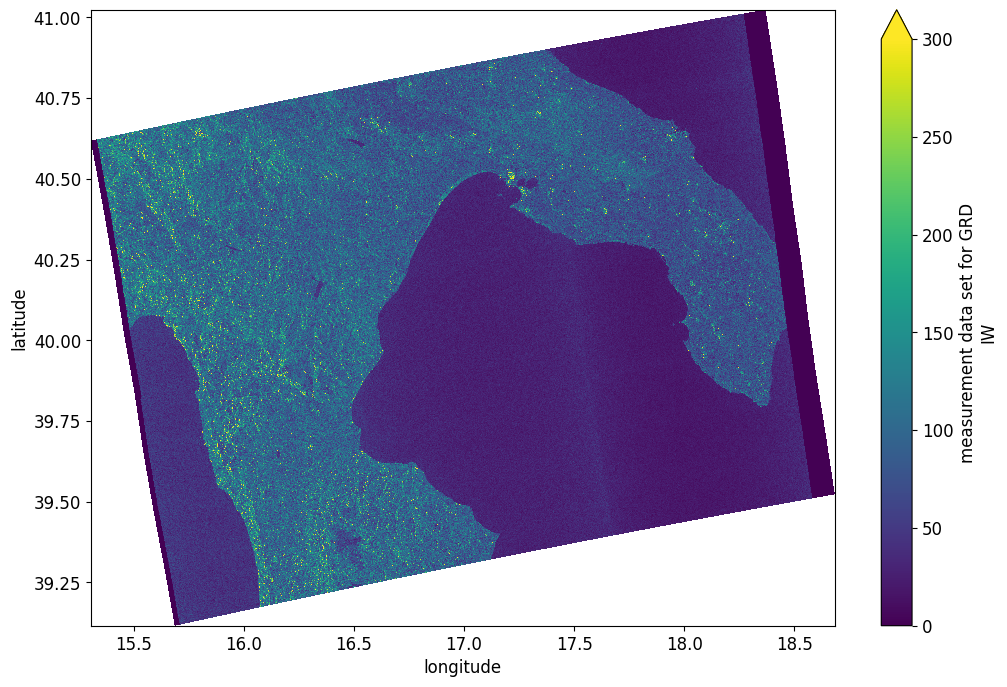

In [81]:
grd.plot(x="longitude", y="latitude", vmax=300)
plt.show()

## Calibrating amplitude and intensity

In **Sentinel-1 GRD** products, only the amplitude of the signal is stored, while the phase information is discarded, unlike Single Look Complex (SLC) products, which preserve both. Therefore, it is essential to calibrate the amplitude using the raw Digital Number (DN) values and the additional metadata provided in the `calibration` subgroup.

The relationship between intensity and amplitude is given by:
$$
\text{Intensity} = |\text{Amplitude}|^2
$$


In [88]:
calibration = dt["/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/quality/calibration"].to_dataset()

### Amplitude

Since amplitude represents the strength of the radar signal that is backscattered and received by the sensor, amplitude calibration is essential to convert raw digital numbers (DN) into physically meaningful amplitude values. This calibration involves applying the `beta_nought` coefficient, which represents the normalized radar backscatter without accounting for the incidence angle.

The result is a calibrated amplitude image, where pixel values approximate the physical radar backscatter amplitude. To perform this calibration, we use the `.calibrate_amplitude()` method from the `xarray_sentinel` library.

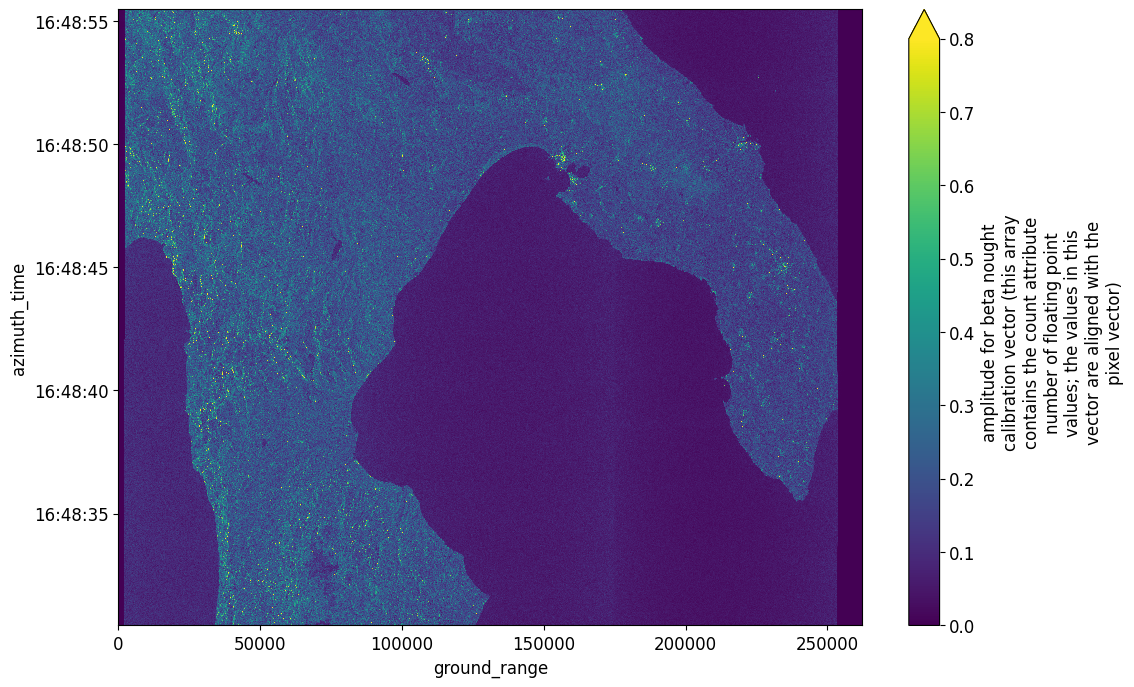

In [92]:
calibrate_amplitude = xarray_sentinel.calibrate_amplitude(
    grd, calibration.beta_nought
)
calibrate_amplitude.plot(vmax=0.8)
plt.show()

### Intensity

Similar to the amplitude calibration process, intensity calibration can be performed using the `.calibrate_intensity()` method from the `xarray_sentinel` library. This method converts the raw Digital Number (DN) values into radar backscatter intensity. The output is a physically meaningful radar brightness image, usually represented in decibels (dB).

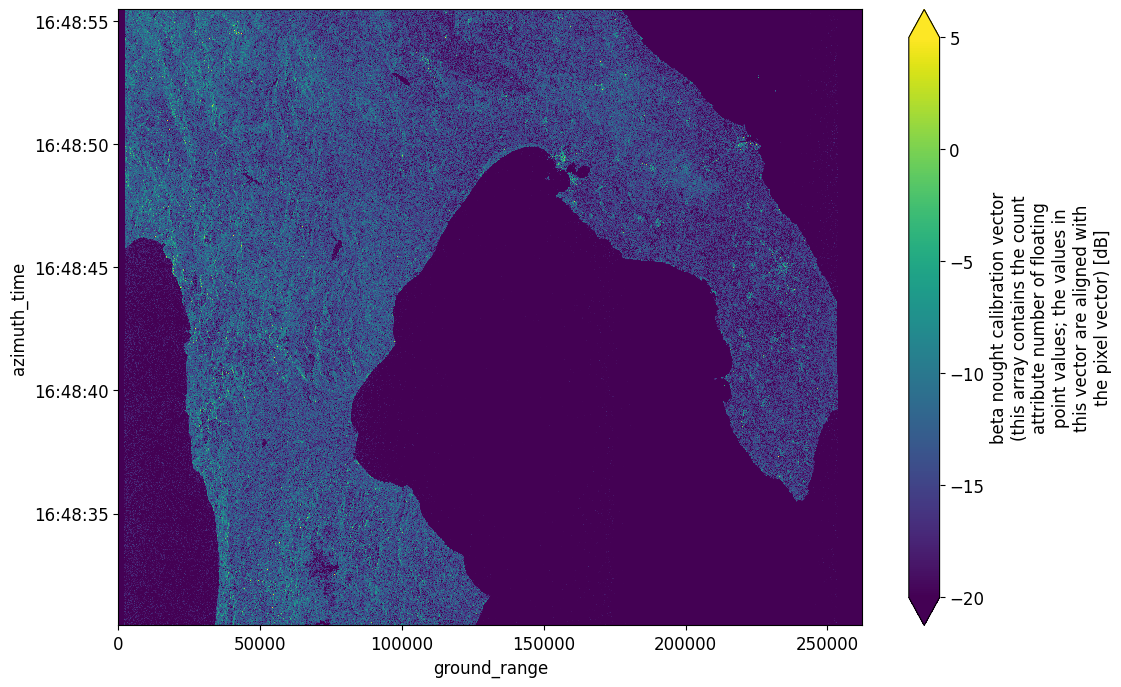

In [100]:
calibrate_intensity = xarray_sentinel.calibrate_intensity(
    grd, calibration.beta_nought, as_db=True
)
calibrate_intensity.plot(vmin=-20, vmax=5)
plt.show()

### Georeferenced intensity

Because we georeferenced the grd image in the `measurements.grd` dataset before performing the calibrations, both `calibrated_amplitude` and `calibrated_intensity` now include not only `azimuth_time` and `ground_range` as coordinates but also `latitude` and `longitude`.

This allows us to create the same calibrated intensity plot as before, but now georeferenced using geographic coordinates (longitude on the x axis and latitude on the y axis).

In [101]:
calibrate_intensity

<xarray.DataArray (azimuth_time: 1670, ground_range: 2624)> Size: 18MB
dask.array<maximum, shape=(1670, 2624), dtype=float32, chunksize=(256, 2624), chunktype=numpy.ndarray>
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 13kB 2017-05-08T16:48:30.4679...
  * ground_range  (ground_range) float64 21kB 0.0 100.0 ... 2.622e+05 2.623e+05
    line          (azimuth_time) float64 13kB dask.array<chunksize=(1670,), meta=np.ndarray>
    pixel         (ground_range) float64 21kB dask.array<chunksize=(2624,), meta=np.ndarray>
    latitude      (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
    longitude     (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
Attributes:
    _eopf_attrs:  {'coordinates': ['azimuth_time', 'line', 'pixel', 'ground_r...
    dtype:        <u2
    long_name:    beta nought calibration vector (this array contains the cou...
    units:        dB

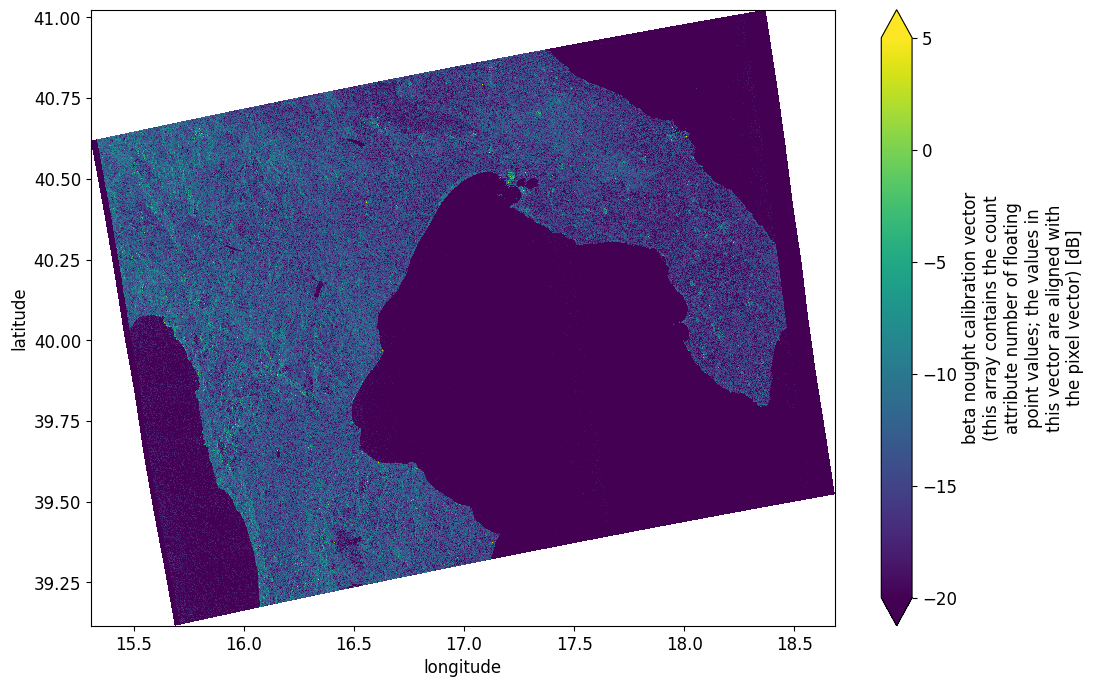

In [104]:
calibrate_intensity.plot(x="longitude", y="latitude", vmin=-20, vmax=5)
plt.show()

<hr>

## 💪 Now it is your turn

The following exercises will help you to better understand the calibration processes studied before.

### Task 1: Reproduce this workflow on a different area
Using what you’ve already learned about the STAC catalog and Sentinel-1 GRD products, repeat this workflow with a different Sentinel-1 GRD scene. Try to use a scene from the area where you live, just like you did on the previous chapter. Then, observe how the geographical coordinates of the georeferenced image differ between products.

### Task 2: Explore intensity and amplitude values
Discover what happens when the maximum and minimum value on x and y axis change. These will create new results, especially when considering the plots on amplitude and intensity calibration.

### Task 3: Compare the intensity values with other datsets
Try to calibrate and plot some grd products from other datasets and see how the intensity values change over different areas, textures and surfaces.


## Conclusion

During this tutorial we've learnt how to compute amplitude and intensity calibration on Sentinel-1 GRD data and how to georeference `measurements.grd` variable into geographical coordinates. For most of the operations we used `xarray_sentinel` methods.

## What's next?

The next [chapter](25_S1_GTC_RTC.ipynb) we'll study a few more opreations that can be performed on Sentinel-1 GRD data. They are a little bit more complex but absolutly necessary for a complete workflow.

Now that you've been introduced to the `.zarr` encoding format, learned its core concepts, and understood the basics of how to explore it, you are prepared for the next step. In the following [chapter](./31_stac_intro.qmd) we will introduce you to **STAC** and the **EOPF Zarr STAC Catalog**. As we go along, we are more and more transition from theory to practice, providing you with hands-on tutorials working with EOPF `.zarr` products.